In [277]:
# General imports
from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
from scipy import signal as sig
from scipy.fft import fft, ifft, ifftshift

In [278]:
# SPE rate / tick / event
# SPErate = 3.12e-3 * pass2

# https://gist.github.com/danstowell/f2d81a897df9e23cc1da
def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the inverse SNR"
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
    return deconvolved

In [279]:
# check if the scipy wiener filter is usable
'''
def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the inverse SNR"
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(sig.wiener(fft(signal), noise=1/lambd)))
    return deconvolved
'''

'\ndef wiener_deconvolution(signal, kernel, lambd):\n    #"lambd is the inverse SNR"\n    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length\n    H = fft(kernel)\n    deconvolved = np.real(ifft(sig.wiener(fft(signal), noise=1/lambd)))\n    return deconvolved\n'

In [280]:
# Wiener deconvolution with lambda as a function of frequency

def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the inverse SNR"
    #kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    # Limit the signal to the length of kernel
    signal = signal[:len(kernel)]
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd)))
    return deconvolved

In [281]:
# Load signal and kernel

%store -r kaligned kraw muon_arr res_fun snrf kfreq

In [282]:
# Syle file for plotting
plt.style.use("LateLightStyle.mplstyle")

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


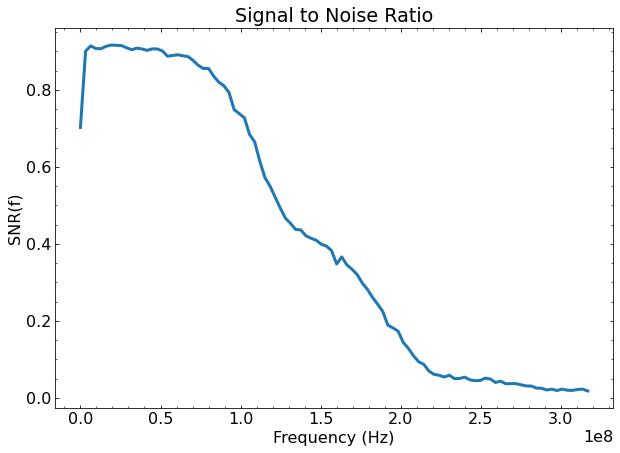

In [283]:
# check snrf

n = 200

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kfreq[:n//2]*10e9, snrf[0:n//2])
ax.set_title("Signal to Noise Ratio")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("SNR(f)")
#ax.set_yscale("log")
#ax.set_ylim(-10,40)
#ax.set_xlim(1.5e8,3.5e8)
plt.show()

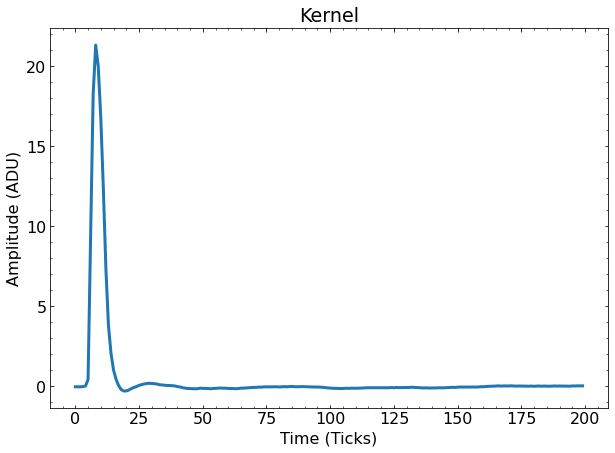

In [284]:
# Check Kernel

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kaligned)
ax.set_title("Kernel")
ax.set_xlabel("Time (Ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_yscale("log")
#ax.set_ylim(-10,40)
#ax.set_xlim(1.5e8,3.5e8)
plt.show()

Deconvolve each waveforms separately, then summing the deconvolved waveforms to get a response function:

In [285]:
# try out different SNR values and compare the deconvolution qualities
# Using time aligned kernel first

dc_muon = []

for i in muon_arr:
    dc_muon.append(wiener_deconvolution(i[0], kaligned, 1/snrf))

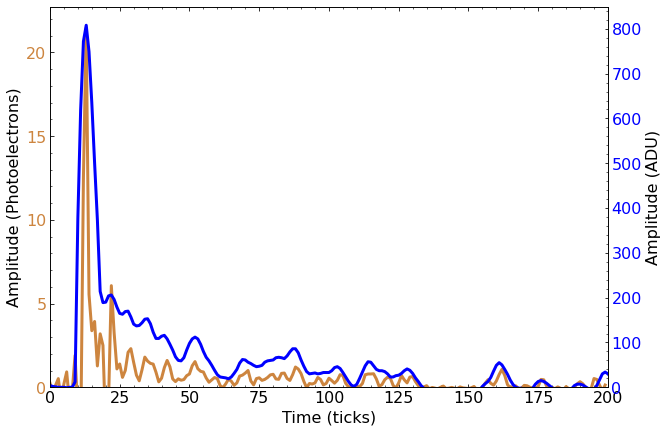

In [286]:
# Demonstrate one deconvolved muon waveform (overlay but with different scales)


fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_muon[0], label="Deconvolved Muon Waveform", color="peru")
ax.tick_params(axis='y', labelcolor="peru")

ax2 = ax.twinx()
ax2.plot(muon_arr[0][0][9:], color="blue", label="Raw Muon Waveform")
ax2.tick_params(axis='y', labelcolor="blue")

plt.xlim(0,200)
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
#ax.set_title("Deconvolved Muon Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
ax2.set_ylabel("Amplitude (ADU)")
plt.show()

### Preliminary Wiener filter SNR study

For more SNR studies please see "SNR value studies and susequent compliation plots"

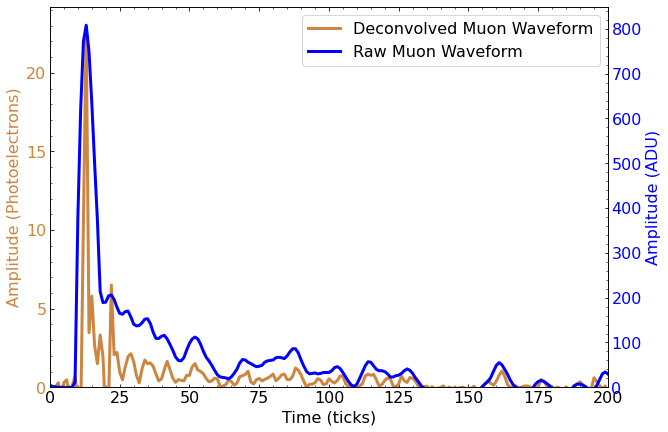

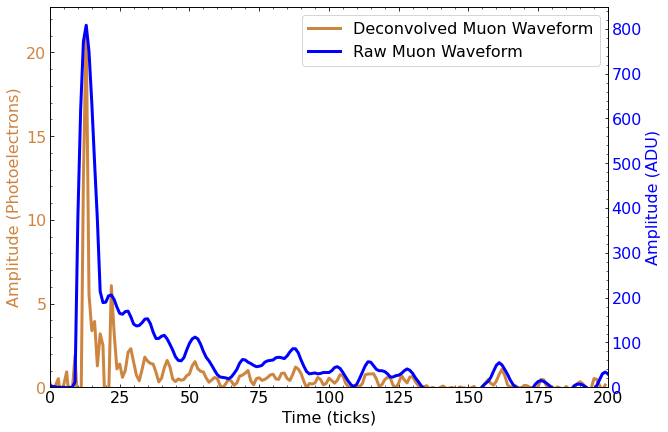

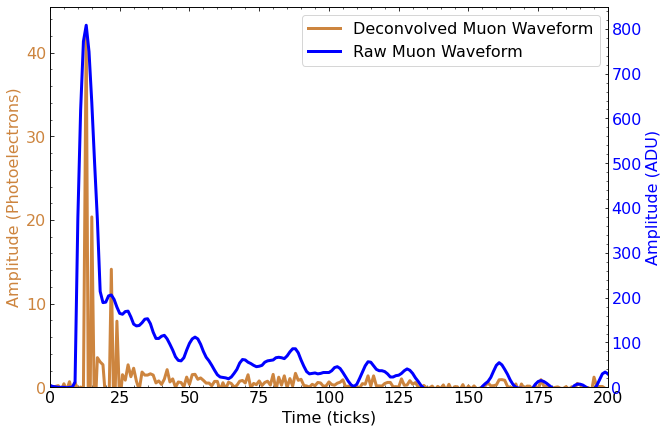

In [287]:
# Use one Muon signal as the subject for now

# Note: according to the github page, the parameter Lambda is the inverse of SNR

#snrvals = [0.001*10**i for i in range(10)]
snrvals = [10, 1/snrf, snrf]

for i in snrvals:
    dcm = wiener_deconvolution(muon_arr[0][0], kaligned, i)
    fig, ax = plt.subplots(figsize =(10, 7))
    lns1 = ax.plot(dcm, label="Deconvolved Muon Waveform", color="peru")
    ax.tick_params(axis='y', labelcolor="peru")

    ax2 = ax.twinx()
    lns2 = ax2.plot(muon_arr[0][0][9:], color="blue", label="Raw Muon Waveform")
    ax2.tick_params(axis='y', labelcolor="blue")
    
    axs = lns1 + lns2
    labs = [a.get_label() for a in axs]
    ax.legend(axs, labs)

    plt.xlim(0,200)
    #ax.set_title(f"SNR = {1/i}")
    ax.set_xlabel("Time (ticks)")
    ax.set_ylabel("Amplitude (Photoelectrons)", color="peru")
    #ax.set_ylim(bottom=-5)
    #ax2.set_ylim(bottom=-200)
    ax.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel("Amplitude (ADU)", color="blue")
    plt.show()

### Deconvolution

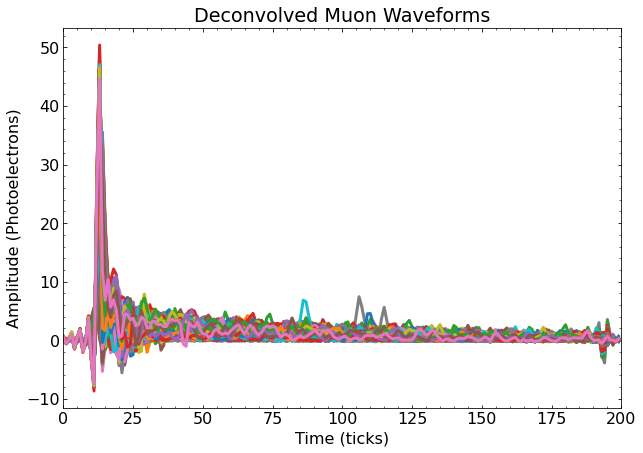

In [288]:
# Overlay all deconvolved waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for i in dc_muon:
    plt.plot(i)
plt.xlim(0,200)
#plt.ylim(-10, 50)
#plt.yscale("log")
ax.set_title("Deconvolved Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.show()

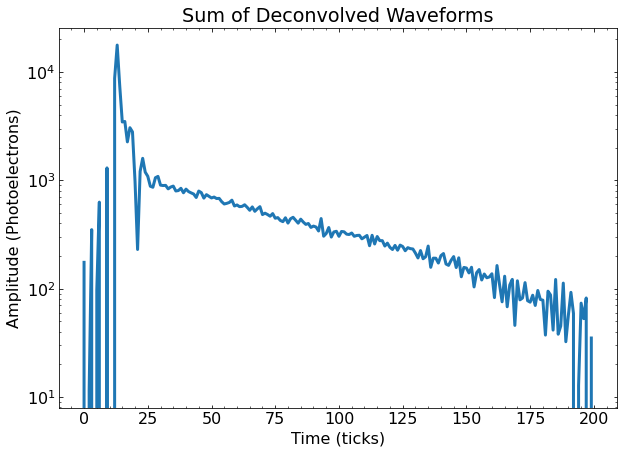

In [289]:
# Sum all deconvolved waveforms for a response function

dc_res = np.zeros(shape=(200,), dtype=object)

for i in range(len(dc_muon)):
    if len(dc_muon[i]) != 0:
        for j in range(len(dc_res)):
            dc_res[j] += dc_muon[i][j]

fig, ax = plt.subplots(figsize =(10, 7))
#fig, ax = plt.subplots(figsize =(5, 7))
plt.plot(dc_res)
#plt.xlim(0,50)
#plt.ylim(-50,400)
ax.set_title("Sum of Deconvolved Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.yscale("log")
plt.show()

Sum the selected waveforms, and deconvolve the response function using the same kernel.

<ipython-input-290-4b069cf16897>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(bottom=0)


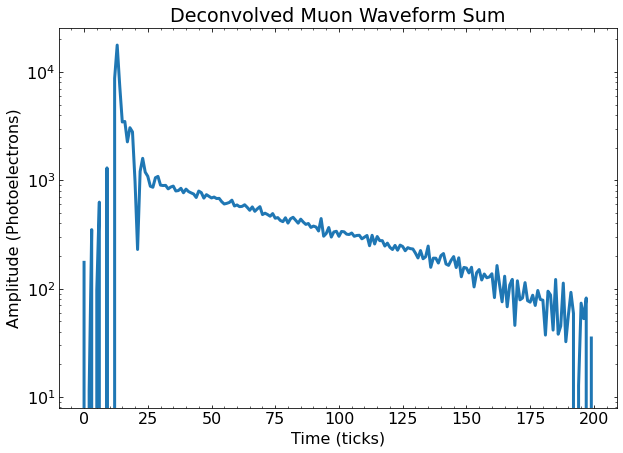

In [290]:
# Deconvolving the response function

dc_res2 = wiener_deconvolution(res_fun, kaligned, 1/snrf)

fig, ax = plt.subplots(figsize =(10, 7))
#fig, ax = plt.subplots(figsize =(5, 7))
plt.plot(dc_res2)
#plt.ylim(-50,400)
plt.yscale("log")
ax.set_ylim(bottom=0)
ax.set_title("Deconvolved Muon Waveform Sum")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.show()

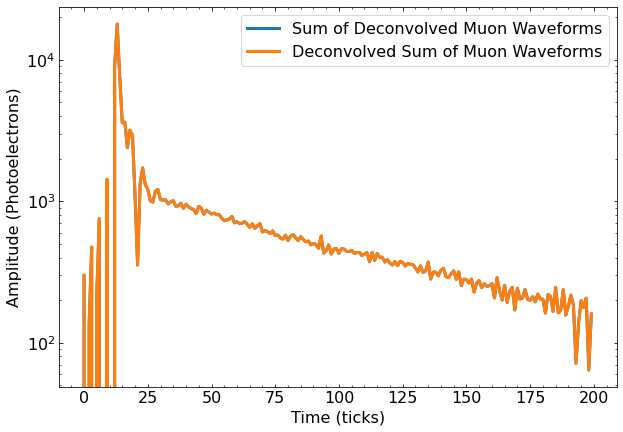

In [291]:
# Overlapping the two response function

fig, ax = plt.subplots(figsize =(10, 7))
plt.plot(dc_res+abs(np.mean(dc_res[:10])), label="Sum of Deconvolved Muon Waveforms")
plt.plot(dc_res2+abs(np.mean(dc_res2[:10])), label="Deconvolved Sum of Muon Waveforms")
#plt.ylim(-50,300)
plt.yscale("log")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.legend()
plt.show()

### Extracting late-light

In [292]:
#'''
def expfun(t, tau, a):
    return a*np.exp(-t/tau)
#'''

# change fitting function to adjust to the new zero point

'''
zp = abs(np.median(dc_res[:10]))

def expfun(t, tau, a):
    return a*np.exp(-t/tau) + zp
'''

# This version is not very applicable to the current model
def expcfun(t, tau, a, b):
    return a*np.exp(-t/tau) + b

#### Extracting late-light without Deconvolution

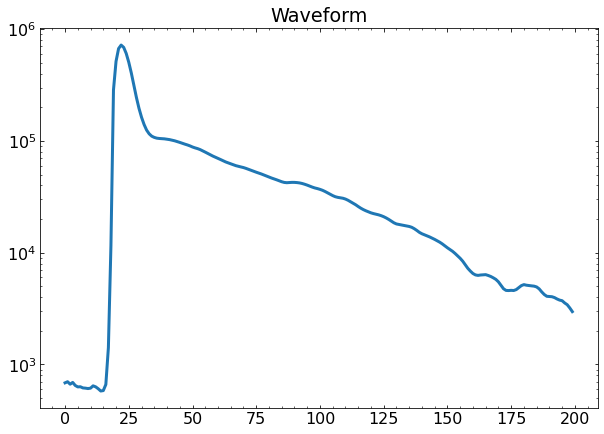

tau = 751.7126247762103 ns


In [293]:
# Exponential fit without constant
#par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(40, len(res_fun), len(res_fun)-40), ydata=res_fun[40:], p0=(10, 96), method="dogbox")
#par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(40, len(res_fun), len(res_fun)-40), ydata=res_fun[40:], p0=(10, 96))
par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(51, 76, 76-51), ydata=res_fun[51:76], p0=(10, 96))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(res_fun)
#ax.plot(np.linspace(0, len(res_fun),len(res_fun)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(res_fun),len(res_fun))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {par[0]*15.625} ns")

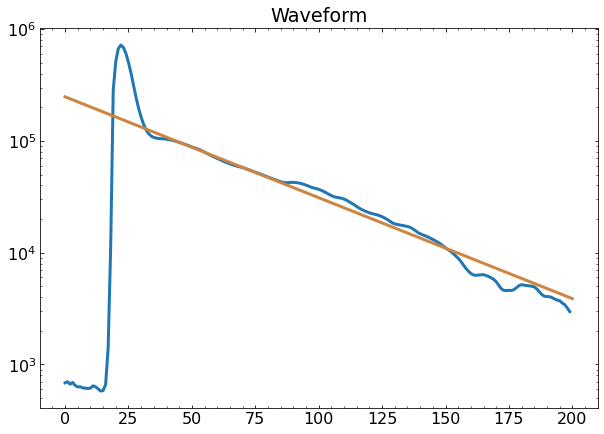

tau = 751.7126247762103 ns


In [294]:
# Plot the same fit in log scale

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(res_fun)
ax.plot(np.linspace(0, len(res_fun),len(res_fun)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(res_fun),len(res_fun))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {par[0]*15.625} ns")

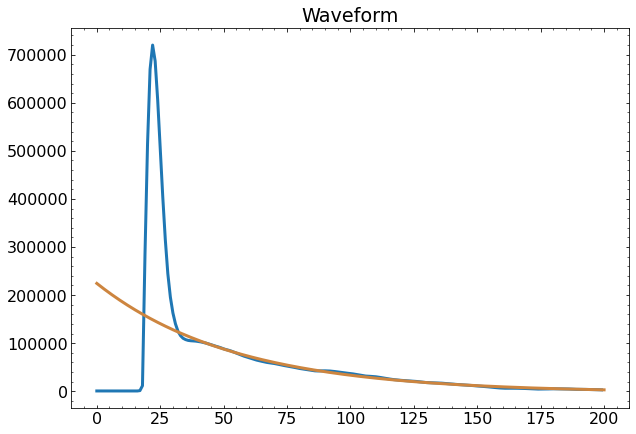

[ 5.43806217e+01  2.27088023e+05 -2.74662729e+03]
tau = 849.6972142546605 ns


In [295]:
# Exponential fit with constant
parc, cov = optimize.curve_fit(f=expcfun, xdata=np.linspace(30, len(res_fun), len(res_fun)-30), ydata=res_fun[30:], p0=(10, 96, 0))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(res_fun)
ax.plot(np.linspace(0, len(res_fun),len(res_fun)), [expcfun(i, parc[0], parc[1], parc[2]) for i in np.linspace(0, len(res_fun),len(res_fun))], color="peru")
ax.set_title("Waveform")
plt.show()

print(parc)
print(f"tau = {parc[0]*15.625} ns")

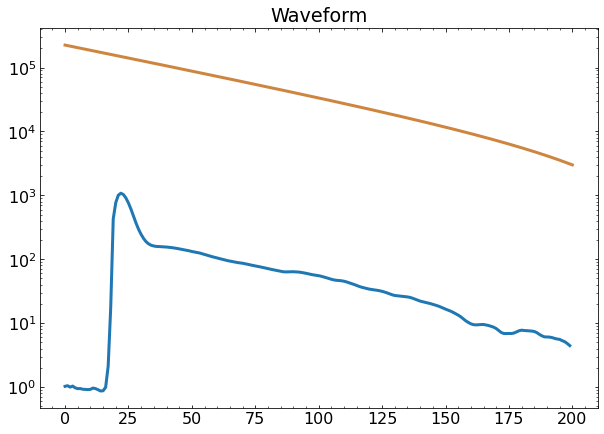

[ 5.43806217e+01  2.27088023e+05 -2.74662729e+03]
tau = 849.6972142546605 ns


In [296]:
# Plot the same fit in log scale

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(res_fun/len(muon_arr))
ax.plot(np.linspace(0, len(res_fun),len(res_fun)), [expcfun(i, parc[0], parc[1], parc[2]) for i in np.linspace(0, len(res_fun),len(res_fun))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(parc)
print(f"tau = {parc[0]*15.625} ns")

Power_divergenceResult(statistic=36136.54420215702, pvalue=0.0)
34861.47466194167


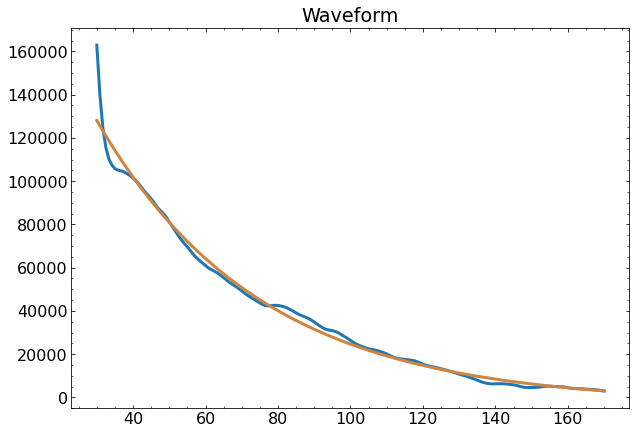

In [297]:
# Calculate chi-square of this fit

resfc_chi = stats.chisquare(res_fun[30:], [expcfun(i, parc[0], parc[1], parc[2]) for i in np.linspace(30, len(res_fun),len(res_fun)-30)])
print(resfc_chi)
print(max(res_fun[30:]-[expcfun(i, parc[0], parc[1], parc[2]) for i in np.linspace(30, len(res_fun),len(res_fun)-30)]))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(np.linspace(30, len(res_fun)-30,len(res_fun)-30), res_fun[30:])
ax.plot(np.linspace(30, len(res_fun)-30,len(res_fun)-30), [expcfun(i, parc[0], parc[1], parc[2]) for i in np.linspace(30, len(res_fun),len(res_fun)-30)], color="peru")
ax.set_title("Waveform")
#plt.yscale("log")
plt.show()

#### Extracting late-light with 1st deconvolution approach 

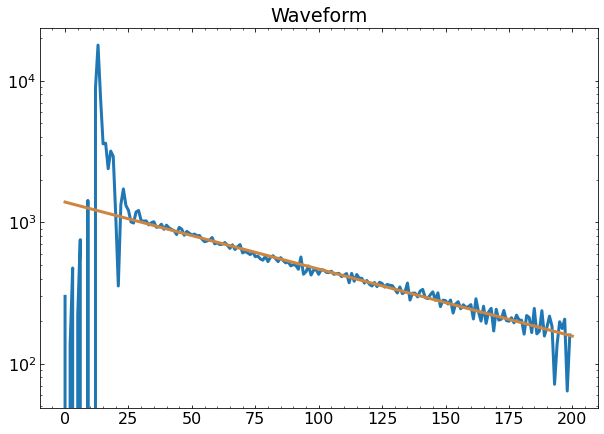

tau = 1433.4113475814213 ns
[  91.73832625 1387.09063886]


In [298]:
# fits for first approach

# Exponential fit without constant
pars, covs = optimize.curve_fit(f=expfun, xdata=np.linspace(40, len(dc_res), len(dc_res)-40), ydata=dc_res[40:]+abs(np.mean(dc_res[:10])), p0=(60, 96))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res+abs(np.mean(dc_res[:10])))
ax.plot(np.linspace(0, len(dc_res),len(dc_res)), [expfun(i, pars[0], pars[1]) for i in np.linspace(0, len(dc_res),len(dc_res))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {pars[0]*15.625} ns")
print(pars)

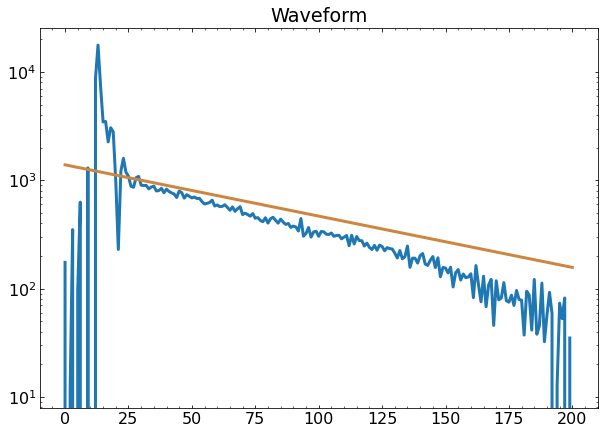

tau = 1433.4113475814213 ns


In [299]:
# Plot the same fit in log scale

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res)
ax.plot(np.linspace(0, len(dc_res),len(dc_res)), [expfun(i, pars[0], pars[1]) for i in np.linspace(0, len(dc_res),len(dc_res))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {pars[0]*15.625} ns")

In [300]:
# Calculate chi-square

dcres_chi = stats.chisquare(dc_res[40:], [expfun(i, pars[0], pars[1]) for i in np.linspace(40, len(dc_res), len(dc_res)-40)])
print(dcres_chi[0]/len(dc_res[40:]))

48.37883611730903


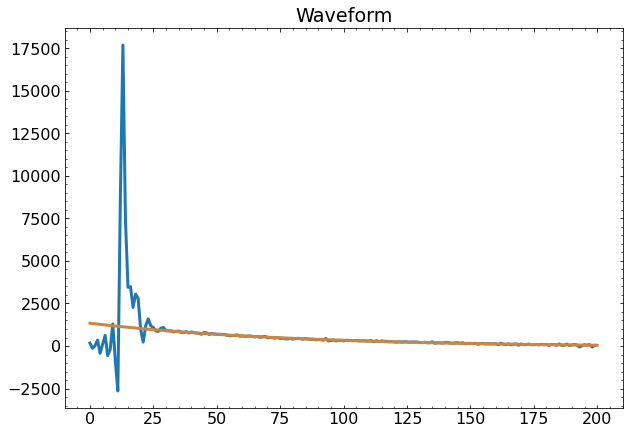

tau = 1258.2547039765784 ns


In [301]:
# Exponential fit with constant

parsc, covc = optimize.curve_fit(f=expcfun, xdata=np.linspace(30, len(dc_res), len(dc_res)-30), ydata=dc_res[30:], p0=(60, 96, 0))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res)
ax.plot(np.linspace(0, len(dc_res),len(dc_res)), [expcfun(i, parsc[0], parsc[1], parsc[2]) for i in np.linspace(0, len(dc_res),len(dc_res))], color="peru")
ax.set_title("Waveform")
plt.show()

print(f"tau = {parsc[0]*15.625} ns")

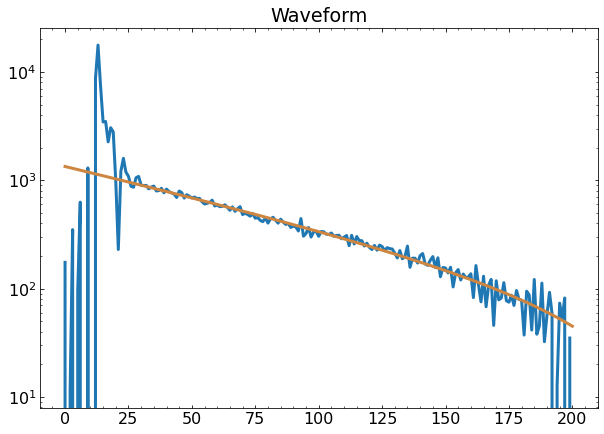

tau = 1258.2547039765784 ns


In [302]:
# Plot the same fit in log scale

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res)
ax.plot(np.linspace(0, len(dc_res),len(dc_res)), [expcfun(i, parsc[0], parsc[1], parsc[2]) for i in np.linspace(0, len(dc_res),len(dc_res))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {parsc[0]*15.625} ns")

In [303]:
# TODO: Problem with current response function:
# Getting skewed by waveforms with rising tail
# too many waveforms with strong ringing/extra small pulses

#### Extracting late light with 2nd deconvolution approach

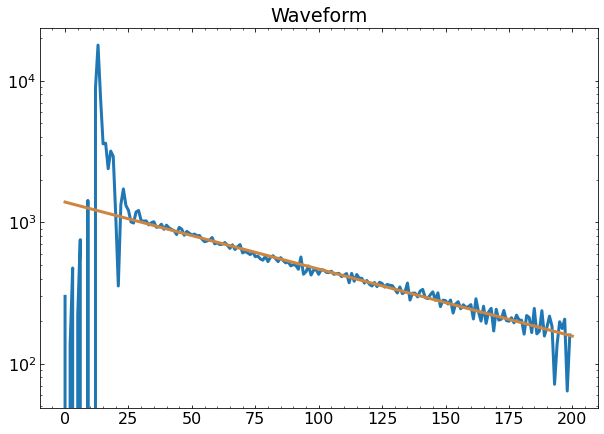

tau = 1433.4113482496705 ns


In [304]:
# fits for first approach

# Exponential fit without constant
pars2, cov2 = optimize.curve_fit(f=expfun, xdata=np.linspace(40, len(dc_res2), len(dc_res2)-40), ydata=dc_res2[40:]+abs(np.mean(dc_res2[:10])), p0=(60, 96))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2+abs(np.mean(dc_res2[:10])))
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expfun(i, pars2[0], pars2[1]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {pars2[0]*15.625} ns")

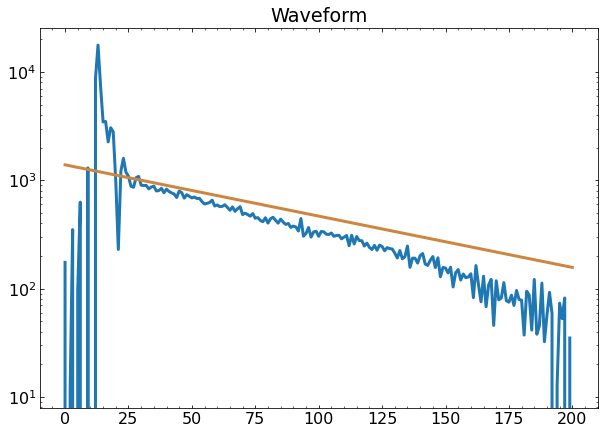

tau = 1433.4113482496705 ns


In [305]:
# Plot the same fit with log scale

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expfun(i, pars2[0], pars2[1]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {pars2[0]*15.625} ns")

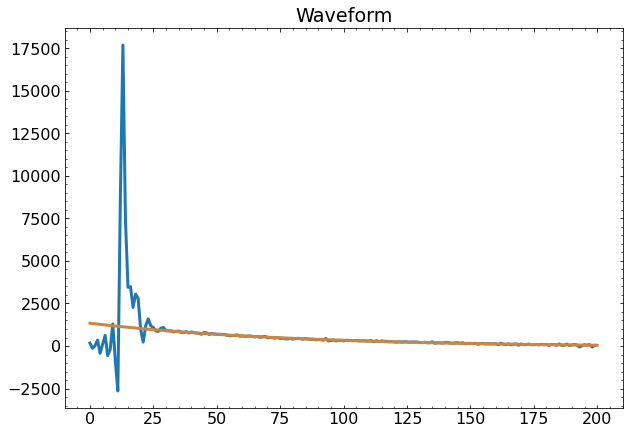

tau = 1258.2525697211695 ns


In [306]:
# Exponential fit with constant

parsc2, covc2 = optimize.curve_fit(f=expcfun, xdata=np.linspace(30, len(dc_res2), len(dc_res2)-30), ydata=dc_res2[30:], p0=(96, 10000, 0))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expcfun(i, parsc2[0], parsc2[1], parsc2[2]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.show()

print(f"tau = {parsc2[0]*15.625} ns")

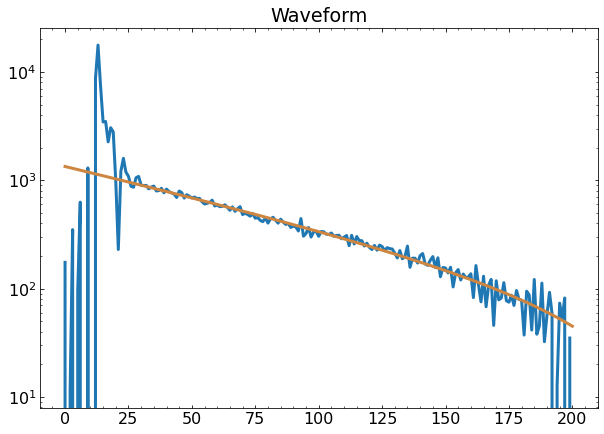

tau = 1258.2525697211695 ns


In [307]:
# Plot the same fit with log scale

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expcfun(i, parsc2[0], parsc2[1], parsc2[2]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {parsc2[0]*15.625} ns")

#### Fit playground

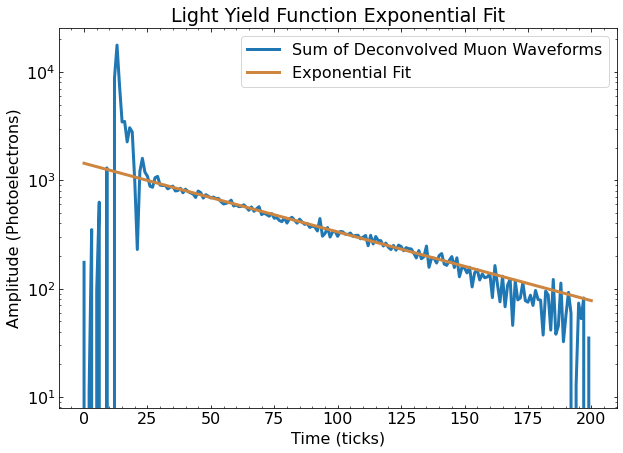

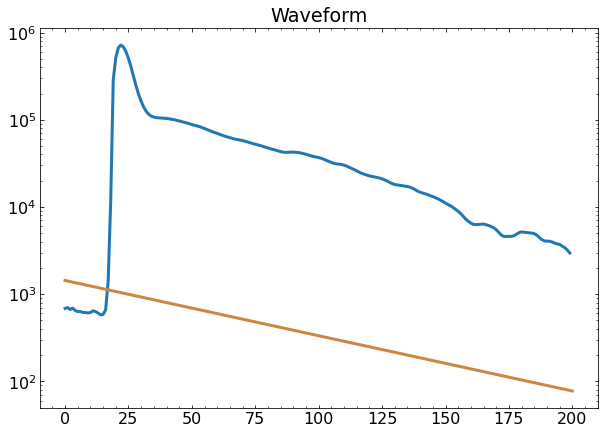

tau = 1070.1604847315616 ns
variance = [  396.12515959 -7372.35877477] ns
[  68.49027102 1434.32111956]
7991737.056738733


In [308]:
st = 50
en = 75

# Exponential fit without constant
#par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(st, en, en-st), ydata=dc_res[st:en]+abs(np.mean(dc_res[:10])), p0=(96, 10000))
par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(st, en, en-st), ydata=dc_res[st:en], p0=(10, 96))

fig, ax = plt.subplots(figsize =(10, 7))
#ax.plot(dc_res+abs(np.mean(dc_res[:10])), label="Sum of Deconvolved Muon Waveforms")
ax.plot(dc_res, label="Sum of Deconvolved Muon Waveforms")
ax.plot(np.linspace(0, len(dc_res),len(dc_res)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(dc_res),len(dc_res))], color="peru", label="Exponential Fit")
plt.legend()
ax.set_title("Light Yield Function Exponential Fit")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.yscale("log")
#plt.ylim(bottom=10e2)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(res_fun)
ax.plot(np.linspace(0, len(res_fun),len(res_fun)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(res_fun),len(res_fun))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {par[0]*15.625} ns")
print(f"variance = {cov[0]*15.625} ns")
print(par)

res_chi = stats.chisquare(res_fun[st:en], [expfun(i, par[0], par[1]) for i in np.linspace(st, en, en-st)])
print(res_chi[0]/len(res_fun[st:en]))

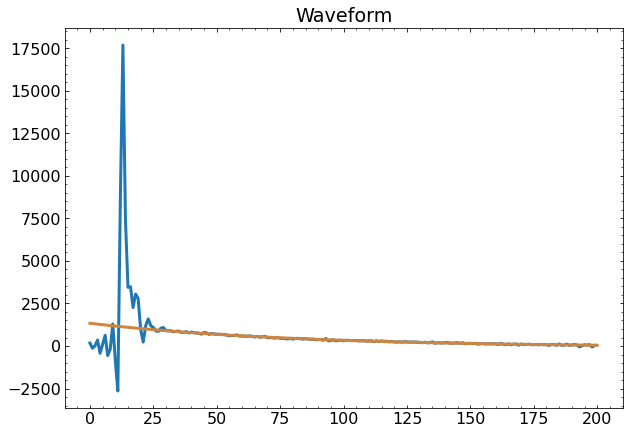

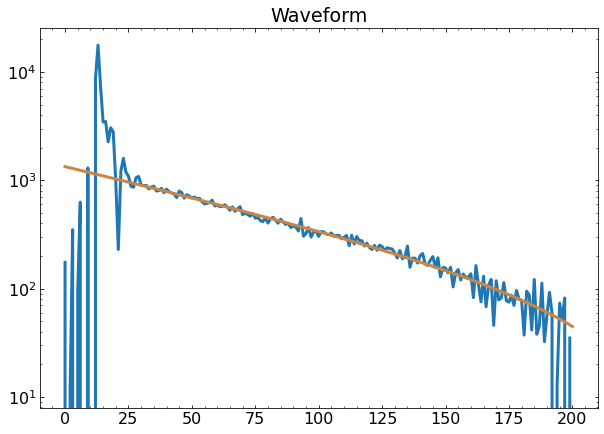

tau = 1262.9154003923557 ns
b = -73.99743360361833
1409.638127108931
Power_divergenceResult(statistic=1044.1966443803547, pvalue=4.651447240261573e-130)
6.526229027377217
6.526229027377215


In [309]:
st = 40
en = 200

# Exponential fit with constant
par, cov = optimize.curve_fit(f=expcfun, xdata=np.linspace(st, en, en-st), ydata=dc_res2[st:en], p0=(10, 96, 0))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expcfun(i, par[0], par[1], par[2]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expcfun(i, par[0], par[1], par[2]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {par[0]*15.625} ns")
print(f"b = {par[2]}")
print(par[1])

res_chi = stats.chisquare(dc_res2[st:en], [expcfun(i, par[0], par[1], par[2]) for i in np.linspace(st, en, en-st)])
expli = [expcfun(i, par[0], par[1], par[2]) for i in np.linspace(st, en, en-st)]
print(res_chi)
print(res_chi[0]/len(dc_res2[st:en]))

print(sum((dc_res2[st:en] - expli)**2/np.abs(expli))/len(dc_res2[st:en]))

### Deconvolution for Background Signal

In [310]:
%store -r nomuon_arr nomuon_res

#### Directly Deconvolving the Summed Response Function

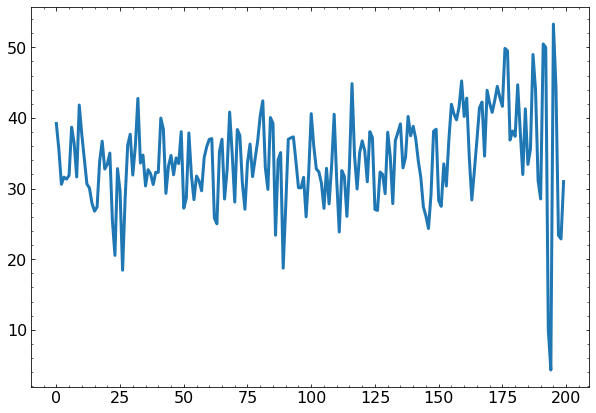

In [311]:
dc_bkg = wiener_deconvolution(nomuon_res, kaligned, 1/snrf)

fig, ax = plt.subplots(figsize =(10, 7))
plt.plot(dc_bkg)
#plt.xlim(0,50)
plt.show()

In [312]:
# TODO: Normalization step needed
print()

#### Deconvolving each waveforms separately

In [313]:
dc_bkgwf = []

for i in nomuon_arr:
    dc_bkgwf.append(wiener_deconvolution(i, kaligned, 1/snrf))

dc_bkg2 = [sum([j[i] for j in dc_bkgwf]) for i in range(len(dc_bkgwf[0]))]
#[sum([nomuon_arr[j][i] for j in range(len(nomuon_arr))]) for i in range(len(nomuon_arr[0]))]

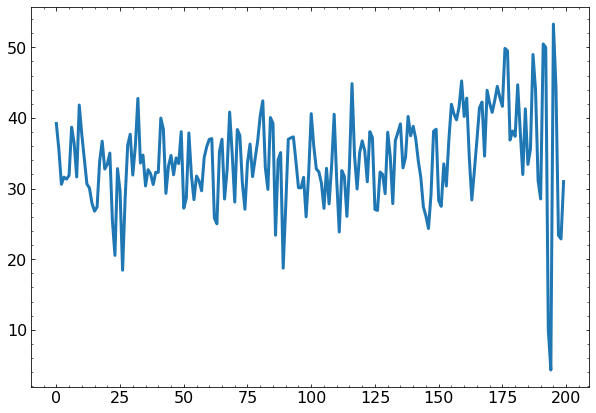

In [314]:
fig, ax = plt.subplots(figsize =(10, 7))
plt.plot(dc_bkg2)
#plt.xlim(0,50)
plt.show()

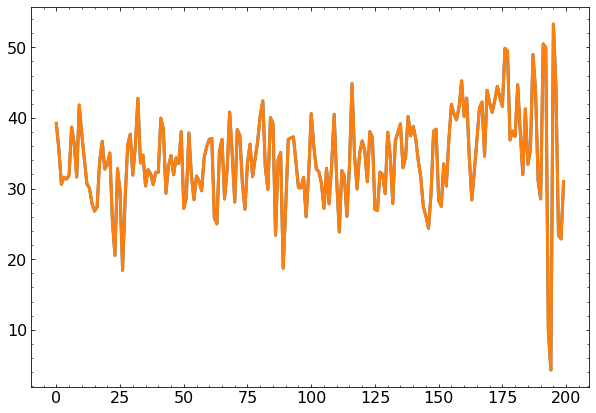

In [315]:
# Overlay the two response functions

fig, ax = plt.subplots(figsize =(10, 7))
plt.plot(dc_bkg)
plt.plot(dc_bkg2)
#plt.xlim(0,50)
plt.show()

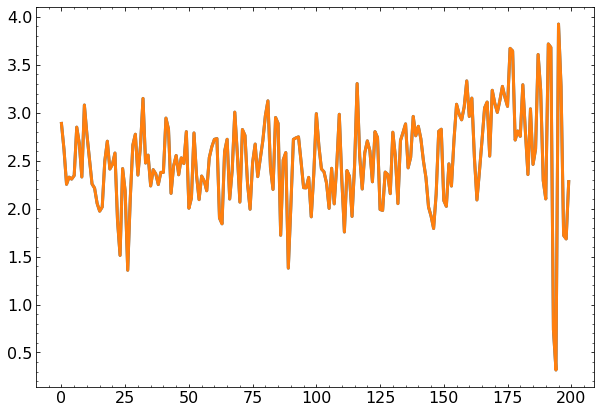

In [316]:
# normalize for usage in response function

nmfactor = len(dc_muon)/len(dc_bkgwf)

# Plot the normalized background
fig, ax = plt.subplots(figsize =(10, 7))
plt.plot(dc_bkg*nmfactor)
#plt.plot(dc_bkg2*nmfactor)
plt.plot([i*nmfactor for i in dc_bkg2])
#plt.xlim(0,50)
plt.show()

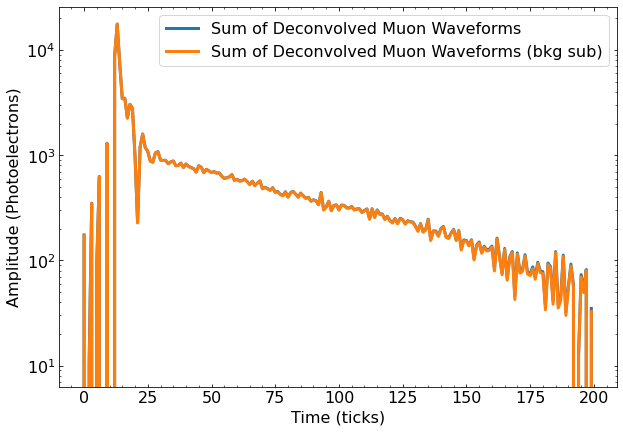

In [317]:
# subtract background

dc_res_sub = dc_res-dc_bkg*nmfactor
dc_res2_sub = dc_res2-[i*nmfactor for i in dc_bkg2]

# Overlapping the two response function

fig, ax = plt.subplots(figsize =(10, 7))
plt.plot(dc_res, label="Sum of Deconvolved Muon Waveforms")
plt.plot(dc_res_sub, label="Sum of Deconvolved Muon Waveforms (bkg sub)")
#plt.plot(dc_res2, label="Deconvolved Sum of Muon Waveforms")
#plt.plot(dc_res2_sub, label="Deconvolved Sum of Muon Waveforms (bkg sub)")
#plt.ylim(-50,300)
plt.yscale("log")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.legend()
plt.show()

### Compliation Plots

In [318]:
# Error estimation for fitting to the ligh yield function

err = np.sqrt(abs(dc_res2))

In [331]:
# Generate fits with different conditions

# Time ranges that will be used
#fitranges = [(40,200), (50,75), (75,100), (100,125), (50,100), (100,150)]
fitranges = [(30,50), (50,70), (70,90), (90,110), (110,130), (130,150), (30,90), (90,150), (30,150)]
# Types of response function
#resli = [res_fun/len(muon_arr), dc_res, dc_res2]
resli = [res_fun, dc_res, dc_res2]
reslitxt = ["res_fun", "dc_res", "dc_res2"]
#resli = [dc_res, dc_res2]
#reslitxt = ["dc_res", "dc_res2"]
# Types of fit functions
funli = [expfun, expcfun]
funlitxt = ["expfun", "expcfun"]

# output parameters arrays
res_fun_pars = np.zeros(3, dtype="object")
res_fun_parsc = np.zeros(3, dtype="object")
dc_res_pars = np.zeros(3, dtype="object")
dc_res_parsc = np.zeros(3, dtype="object")
dc_res2_pars = np.zeros(3, dtype="object")
dc_res2_parsc = np.zeros(3, dtype="object")

resparsli = [res_fun_pars, dc_res_pars, dc_res2_pars]
resparscli = [res_fun_parsc, dc_res_parsc, dc_res2_parsc]

for j in range(len(resli)):
    for i in fitranges:
        # Fitting without constant
        #parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=resli[j][i[0]:i[1]]+abs(np.mean(resli[j][:10])), p0=(10, 96))
        yfunc = np.array([i for i in resli[j][i[0]:i[1]]])
        parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=yfunc, p0=(10, 96), sigma=np.abs(yfunc)**0.5)
        unccache = np.sqrt(np.diag(covcache))
        parnm = str(i[0])+"-"+str(i[1])
        resparsli[j] = np.vstack((resparsli[j], [parnm, parcache, unccache]))
        # Fitting with constant
        #parcache, covcache = optimize.curve_fit(f=expcfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=resli[j][i[0]:i[1]], p0=(10, 96, 0), sigma=err[i[0]:i[1]])
        #unccache = np.sqrt(np.diag(covcache))
        #parnm = str(i[0])+"-"+str(i[1])
        #resparscli[j] = np.vstack((resparscli[j], [parnm, parcache, unccache]))
    resparsli[j] = resparsli[j][1:]
    resparscli[j] = resparscli[j][1:]

In [332]:
print(resparsli[1])
print([resparsli[1][:,1][i][0] for i in range(len(resparsli[1]))])

[['30-50' array([  82.54474076, 1292.29278538])
  array([10.25230905, 77.80664225])]
 ['50-70' array([  77.16253773, 1307.02058955])
  array([  8.74885949, 114.89954311])]
 ['70-90' array([  87.81355212, 1081.81170685])
  array([ 12.59773602, 141.05338703])]
 ['90-110' array([ 99.50725787, 899.34811411])
  array([ 29.90050099, 271.07123484])]
 ['110-130' array([  74.03142634, 1294.73659878])
  array([ 13.93484459, 393.91952815])]
 ['130-150' array([  70.4327483 , 1337.35433426])
  array([ 22.20347129, 835.67240846])]
 ['30-90' array([  68.85826744, 1416.15952442])
  array([ 1.5126466, 26.2906341])]
 ['90-150' array([  71.49884429, 1334.29893005])
  array([  3.38399525, 103.35518976])]
 ['30-150' array([  69.46658296, 1402.67775243])
  array([ 0.81667247, 19.0219545 ])]]
[82.54474076476248, 77.162537730342, 87.81355212238977, 99.50725787460804, 74.0314263382349, 70.43274829761809, 68.85826744079282, 71.49884428656911, 69.46658295754433]


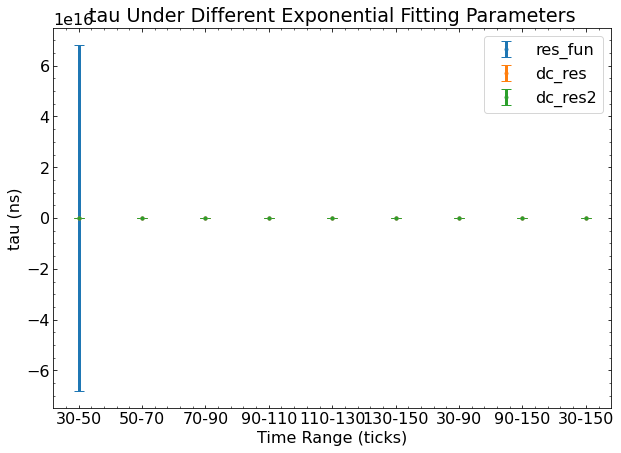

'\nfig, ax = plt.subplots(figsize =(10, 7))\nk = 0\nfor i in resparscli:\n    # Convert units from ticks to ns (15.625ns/tick)\n    plt.errorbar([j for j in range(len(i))], [i[:,1][j][0]*15.625 for j in range(len(i))], yerr=[i[:,2][j][0]*15.625 for j in range(len(i))], ls="None", label=reslitxt[k], capsize=5., marker=".")\n    k += 1\nplt.xticks(np.arange(len(resparscli[0])), [resparscli[0][:,0][j] for j in range(len(resparscli[0]))])\nplt.legend()\nplt.title("tau Under Different Exponential (with constant) Fitting Parameters")\nplt.xlabel("Time Range (ticks)")\nplt.ylabel("tau (ns)")\nplt.show()\n'

In [333]:
# Make Compliation plots
# CAUTION: raw tau is in units of ticks!

# Fitting without constant
fig, ax = plt.subplots(figsize =(10, 7))
k = 0
for i in resparsli:
    # Convert units from ticks to ns (15.625ns/tick)
    plt.errorbar([j for j in range(len(i))], [i[:,1][j][0]*15.625 for j in range(len(i))], yerr=[i[:,2][j][0]*15.625 for j in range(len(i))], ls="None", label=reslitxt[k], capsize=5., marker=".")
    k += 1
plt.xticks(np.arange(len(resparsli[0])), [resparsli[0][:,0][j] for j in range(len(resparsli[0]))])
plt.legend()
plt.title("tau Under Different Exponential Fitting Parameters")
plt.xlabel("Time Range (ticks)")
plt.ylabel("tau (ns)")
plt.show()

# Fitting with constant
'''
fig, ax = plt.subplots(figsize =(10, 7))
k = 0
for i in resparscli:
    # Convert units from ticks to ns (15.625ns/tick)
    plt.errorbar([j for j in range(len(i))], [i[:,1][j][0]*15.625 for j in range(len(i))], yerr=[i[:,2][j][0]*15.625 for j in range(len(i))], ls="None", label=reslitxt[k], capsize=5., marker=".")
    k += 1
plt.xticks(np.arange(len(resparscli[0])), [resparscli[0][:,0][j] for j in range(len(resparscli[0]))])
plt.legend()
plt.title("tau Under Different Exponential (with constant) Fitting Parameters")
plt.xlabel("Time Range (ticks)")
plt.ylabel("tau (ns)")
plt.show()
'''


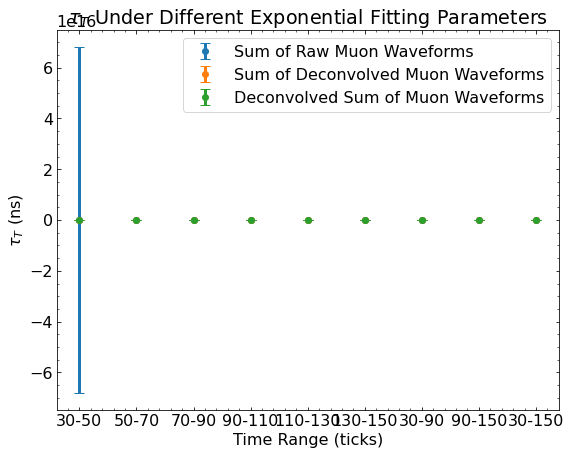

In [334]:
# Do better formatting

# Fitting without constant
fig, ax = plt.subplots(figsize =(9, 7))
# Convert units from ticks to ns (15.625ns/tick)
plt.errorbar([j for j in range(len(resparsli[0]))], [resparsli[0][:,1][j][0]*15.625 for j in range(len(resparsli[0]))], yerr=[resparsli[0][:,2][j][0]*15.625 for j in range(len(resparsli[0]))], ls="None", label="Sum of Raw Muon Waveforms", capsize=5., marker="o")
plt.errorbar([j for j in range(len(resparsli[1]))], [resparsli[1][:,1][j][0]*15.625 for j in range(len(resparsli[1]))], yerr=[resparsli[1][:,2][j][0]*15.625 for j in range(len(resparsli[1]))], ls="None", label="Sum of Deconvolved Muon Waveforms", capsize=5., marker="o")
plt.errorbar([j for j in range(len(resparsli[2]))], [resparsli[2][:,1][j][0]*15.625 for j in range(len(resparsli[2]))], yerr=[resparsli[2][:,2][j][0]*15.625 for j in range(len(resparsli[2]))], ls="None", label="Deconvolved Sum of Muon Waveforms", capsize=5., marker="o")

#plt.errorbar([j for j in range(len(resparsli[0]))], [resparsli[0][:,1][j][0]*15.625 for j in range(len(resparsli[0]))], yerr=[resparsli[0][:,2][j][0]*15.625 for j in range(len(resparsli[0]))], ls="None", label="Sum of Deconvolved Muon Waveforms", capsize=5., marker="o")
#plt.errorbar([j for j in range(len(resparsli[1]))], [resparsli[1][:,1][j][0]*15.625 for j in range(len(resparsli[1]))], yerr=[resparsli[1][:,2][j][0]*15.625 for j in range(len(resparsli[1]))], ls="None", label="Deconvolved Sum of Muon Waveforms", capsize=5., marker="o")

plt.xticks(np.arange(len(resparsli[0])), [resparsli[0][:,0][j] for j in range(len(resparsli[0]))])
plt.legend()
plt.title(r"$\tau_T$ Under Different Exponential Fitting Parameters")
plt.xlabel("Time Range (ticks)")
plt.ylabel(r"$\tau_T$ (ns)")
#plt.ylim(600,1500)
plt.show()

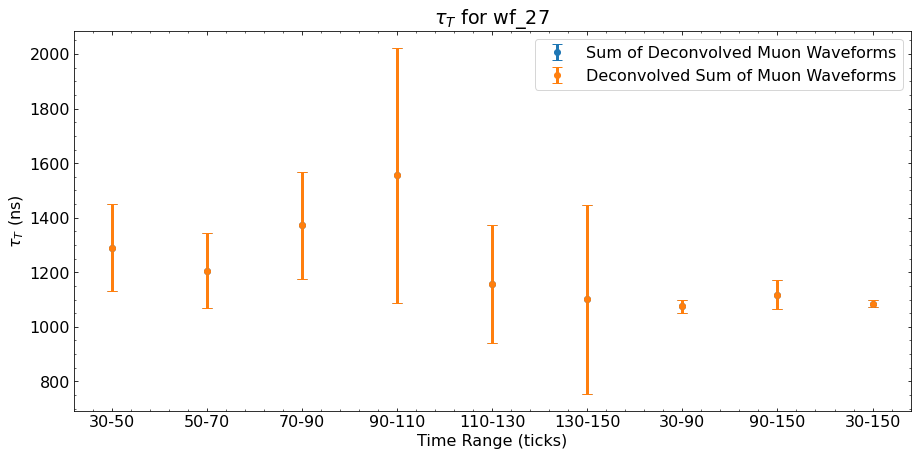

In [335]:
# Do better formatting
# And more detailed time ranges

# Fitting without constant
fig, ax = plt.subplots(figsize =(15, 7))
# Convert units from ticks to ns (15.625ns/tick)
#plt.errorbar([j for j in range(len(resparsli[0]))], [resparsli[0][:,1][j][0]*15.625 for j in range(len(resparsli[0]))], yerr=[resparsli[0][:,2][j][0]*15.625 for j in range(len(resparsli[0]))], ls="None", label="Sum of Raw Muon Waveforms", capsize=5., marker="o")
plt.errorbar([j for j in range(len(resparsli[1]))], [resparsli[1][:,1][j][0]*15.625 for j in range(len(resparsli[1]))], yerr=[resparsli[1][:,2][j][0]*15.625 for j in range(len(resparsli[1]))], ls="None", label="Sum of Deconvolved Muon Waveforms", capsize=5., marker="o")
plt.errorbar([j for j in range(len(resparsli[2]))], [resparsli[2][:,1][j][0]*15.625 for j in range(len(resparsli[2]))], yerr=[resparsli[2][:,2][j][0]*15.625 for j in range(len(resparsli[2]))], ls="None", label="Deconvolved Sum of Muon Waveforms", capsize=5., marker="o")

#plt.errorbar([j for j in range(len(resparsli[0]))], [resparsli[0][:,1][j][0]*15.625 for j in range(len(resparsli[0]))], yerr=[resparsli[0][:,2][j][0]*15.625 for j in range(len(resparsli[0]))], ls="None", label="Sum of Deconvolved Muon Waveforms", capsize=5., marker="o")
#plt.errorbar([j for j in range(len(resparsli[1]))], [resparsli[1][:,1][j][0]*15.625 for j in range(len(resparsli[1]))], yerr=[resparsli[1][:,2][j][0]*15.625 for j in range(len(resparsli[1]))], ls="None", label="Deconvolved Sum of Muon Waveforms", capsize=5., marker="o")

plt.xticks(np.arange(len(resparsli[0])), [resparsli[0][:,0][j] for j in range(len(resparsli[0]))])
plt.legend()
#plt.title(r"$\tau_T$ Under Different Exponential Fitting Parameters")
plt.title(r"$\tau_T$ for wf_27")
plt.xlabel("Time Range (ticks)")
plt.ylabel(r"$\tau_T$ (ns)")
#plt.ylim(600,1500)
plt.show()

#### SNR value studies and susequent compliation plots

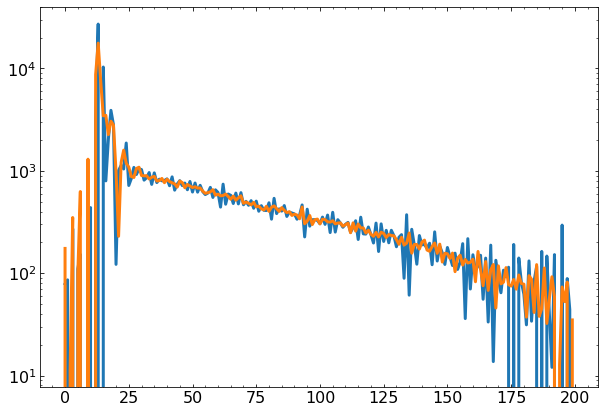

In [324]:
# Generate deconvolution results for each snr

#snrvals = [0.001*10**i for i in range(10)]
snrvals = [1, 1/snrf]
dcmarr = np.zeros((len(snrvals), 200), dtype="object")
dcmsarr = np.zeros((len(snrvals), 200), dtype="object")

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(dcmarr)):
    dc_cache = []
    '''
    for j in muon_arr:
        dc_cache.append(wiener_deconvolution(j[0], kaligned, snrvals[i]))
    fig, ax = plt.subplots(figsize =(10, 7))
    for k in dc_cache:
        plt.plot(k)
    plt.xlim(0,200)
    #plt.ylim(-10, 50)
    #plt.yscale("log")
    ax.set_title("Deconvolved Muon Waveforms")
    ax.set_xlabel("Time (ticks)")
    ax.set_ylabel("Amplitude (Photoelectrons)")
    plt.show()
    '''
    # Compile the deconvolved waveforms and compare them with the raw waveforms
    '''
    fig, ax = plt.subplots(figsize =(10, 7))
    
    for m in range(len(dc_cache)):
        lns1 = ax.plot(dcm, label="Deconvolved Muon Waveform", color="peru", alpha=0.3)
        ax.tick_params(axis='y', labelcolor="peru")

        ax2 = ax.twinx()
        lns2 = ax2.plot(muon_arr[0][0][9:], color="blue", label="Raw Muon Waveform", alpha=0.3)
        ax2.tick_params(axis='y', labelcolor="blue")

        axs = lns1 + lns2
        labs = [a.get_label() for a in axs]
        ax.legend(axs, labs)

    plt.xlim(0,200)
    ax.set_title(f"SNR = {1/i}")
    ax.set_xlabel("Time (ticks)")
    ax.set_ylabel("Amplitude (Photoelectrons)", color="peru")
    #ax.set_ylim(bottom=-5)
    #ax2.set_ylim(bottom=-200)
    ax.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel("Amplitude (ADU)", color="blue")
    plt.show()
    '''
    
    dcmarr[i]=[sum([k[l] for k in dc_cache]) for l in range(200)]
    dcmsarr[i]=wiener_deconvolution(res_fun, kaligned, snrvals[i])
    # Plot the deconvolved response functions
    #fig, ax = plt.subplots(figsize =(10, 7))
    #ax.plot(dcmarr[i], label="Sum of Deconvolved Waveforms")
    ax.plot(dcmsarr[i], label="Deconvolved Muon Waveform Sum")
    #plt.title(f"Deconvolved Muon Waveform Sum(SNR = {snrvals[i]})")
    #plt.title("Sum of Deconvolved Waveforms")
    plt.yscale("log")
    #plt.legend()
plt.show()

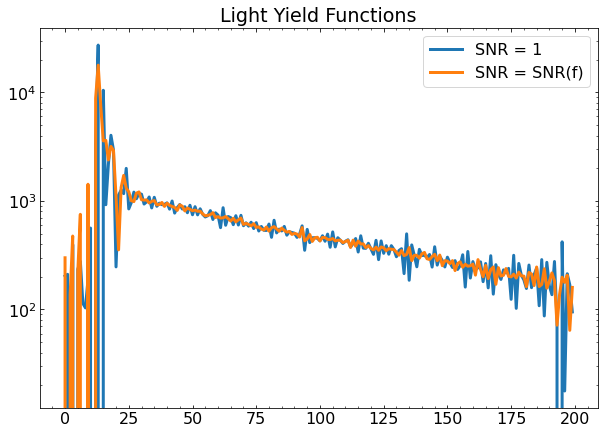

In [325]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dcmsarr[0]+abs(np.mean(dc_res[:10])), label="SNR = 1")
ax.plot(dcmsarr[i]+abs(np.mean(dc_res[:10])), label="SNR = SNR(f)")
plt.title("Light Yield Functions")
plt.yscale("log")
plt.legend()
plt.show()

In [326]:
# Generate fitting data
# TODO: Double check this

parsarr = [[np.zeros(3, dtype=object) for j in range(2)] for i in range(len(snrvals))]

for j in range(len(parsarr)):
    for i in fitranges:
        # Fitting without constant (Sum of Deconvolved Waveforms)
        #parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=dcmarr[j][i[0]:i[1]]+abs(np.mean(dcmarr[j][:10])), p0=(10, 96))
        parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=dcmarr[j][i[0]:i[1]], p0=(10, 96))
        unccache = np.sqrt(np.diag(covcache))
        parnm = f"{str(i[0])}-{str(i[1])}"
        parsarr[j][0] = np.vstack((parsarr[j][0], [parnm, parcache, unccache]))
        # Fitting without constant (Deconvolved Waveform Sum)
        parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=dcmsarr[j][i[0]:i[1]], p0=(10, 96))
        unccache = np.sqrt(np.diag(covcache))
        parnm = f"{str(i[0])}-{str(i[1])}"
        parsarr[j][1] = np.vstack((parsarr[j][1], [parnm, parcache, unccache]))

# Clean up the zero rows
for i in parsarr:
    for j in range(len(i)):
        i[j] = i[j][1:]

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


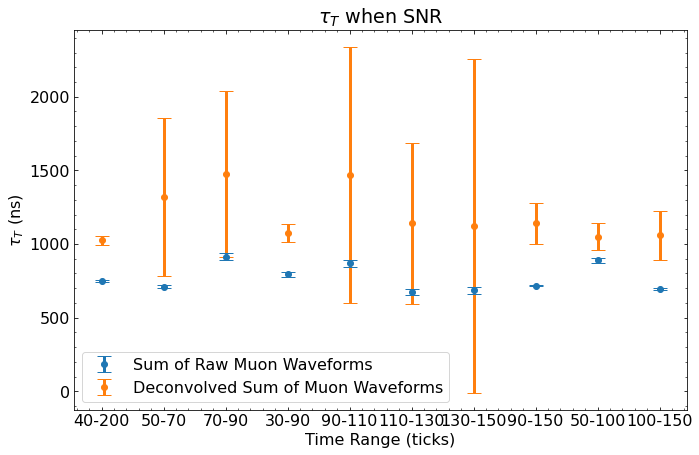

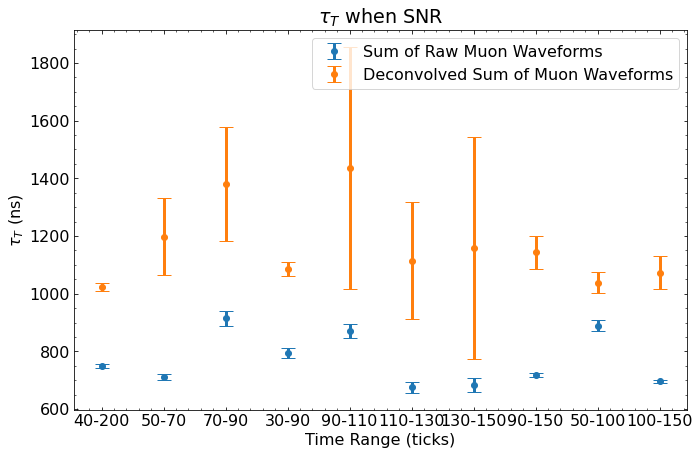

In [327]:
for i in range(len(parsarr)):
    fig, ax = plt.subplots(figsize =(11, 7))
    # Convert units from ticks to ns (15.625ns/tick)
    plt.errorbar([j for j in range(len(resparsli[0]))], [resparsli[0][:,1][j][0]*15.625 for j in range(len(resparsli[0]))], yerr=[resparsli[0][:,2][j][0]*15.625 for j in range(len(resparsli[0]))], ls="None", label="Sum of Raw Muon Waveforms", capsize=7., marker="o")
    #plt.errorbar([j for j in range(len(parsarr[i][0]))], [parsarr[i][0][:,1][j][0]*15.625 for j in range(len(parsarr[i][0]))], yerr=[parsarr[i][0][:,2][j][0]*15.625 for j in range(len(parsarr[i][0]))], ls="None", label="Sum of Deconvolved Muon Waveforms", capsize=7., marker="o")
    plt.errorbar([j for j in range(len(parsarr[i][1]))], [parsarr[i][1][:,1][j][0]*15.625 for j in range(len(parsarr[i][1]))], yerr=[parsarr[i][1][:,2][j][0]*15.625 for j in range(len(parsarr[i][1]))], ls="None", label="Deconvolved Sum of Muon Waveforms", capsize=7., marker="o")
    plt.xticks(np.arange(len(parsarr[i][0])), [parsarr[i][0][:,0][j] for j in range(len(parsarr[i][0]))])
    plt.legend()
    plt.title(fr"$\tau_T$ when SNR")
    #plt.title(fr"$\tau_T$ under Different Exponential Fitting Parameters")
    plt.xlabel("Time Range (ticks)")
    plt.ylabel(r"$\tau_T$ (ns)")
    plt.show()

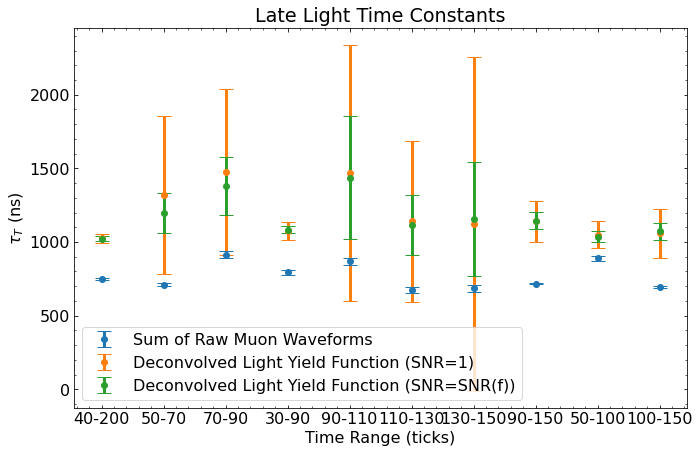

In [328]:
fig, ax = plt.subplots(figsize =(11, 7))
# Convert units from ticks to ns (15.625ns/tick)
plt.errorbar([j for j in range(len(resparsli[0]))], [resparsli[0][:,1][j][0]*15.625 for j in range(len(resparsli[0]))], yerr=[resparsli[0][:,2][j][0]*15.625 for j in range(len(resparsli[0]))], ls="None", label="Sum of Raw Muon Waveforms", capsize=7., marker="o")
plt.errorbar([j for j in range(len(parsarr[0][1]))], [parsarr[0][1][:,1][j][0]*15.625 for j in range(len(parsarr[0][1]))], yerr=[parsarr[0][1][:,2][j][0]*15.625 for j in range(len(parsarr[0][1]))], ls="None", label="Deconvolved Light Yield Function (SNR=1)", capsize=7., marker="o")
plt.errorbar([j for j in range(len(parsarr[1][1]))], [parsarr[1][1][:,1][j][0]*15.625 for j in range(len(parsarr[1][1]))], yerr=[parsarr[1][1][:,2][j][0]*15.625 for j in range(len(parsarr[1][1]))], ls="None", label="Deconvolved Light Yield Function (SNR=SNR(f))", capsize=7., marker="o")
plt.xticks(np.arange(len(parsarr[i][0])), [parsarr[i][0][:,0][j] for j in range(len(parsarr[i][0]))])
plt.legend()
plt.title("Late Light Time Constants")
#plt.title(fr"$\tau_T$ under Different Exponential Fitting Parameters")
plt.xlabel("Time Range (ticks)")
plt.ylabel(r"$\tau_T$ (ns)")
plt.show()

### Measurement with the Xenon impurity model

In [329]:
# Reference: https://indico.cern.ch/event/981823/contributions/4293602/attachments/2250275/3817149/Soto_TIPP2021_Xenon.pdf
# slide 14

def xexpfun(t, tau_slow, a1, tau_trans, a2):
    return a1*np.exp(-t/tau_slow) - a2*np.exp(-t/tau_trans)


In [330]:
# Try the fit on the deconvolved result

m = len(dc_res2)

# Exponential fit without constant
#xpars, xcov = optimize.curve_fit(f=xexpfun, xdata=np.linspace(40, m, m-40), ydata=dc_res2[40:]+abs(np.mean(dc_res2[:10])), p0=(60, 96))
xpars, xcov = optimize.curve_fit(f=xexpfun, xdata=np.linspace(40, m, m-40), ydata=dc_res2[40:]+abs(np.mean(dc_res2[:10])), p0=(60, 96, 60, ))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2+abs(np.mean(dc_res2[:10])))
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [xexpfun(i, xpars[0], xpars[1], xpars[2], xpars[3]) for i in np.linspace(0, m, m)], color="peru")
ax.set_title("Waveform")
#plt.yscale("log")
plt.show()

print(f"tau_slow = {xpars[0]*15.625} ns")
print(f"tau_trans = {xpars[2]*15.625} ns")

TypeError: xexpfun() missing 1 required positional argument: 'a2'

### Analytic Fitting Method

In [ ]:
# Calculate the error for each data point on the sum of the deconvolved waveforms light yield function

#err =[np.sqrt(len(dc_muon))*np.std([i[j] for i in dc_muon]) for j in range(len(dc_muon[0]))]

err = np.sqrt(abs(dc_res2))

print(len(err))
print(len(dc_muon))

In [ ]:
print(dc_res2[150:200])
print(err[150:200])

In [ ]:
# first try doing the same fit with uncertainties

# TODO: clearly doesn't work when fitting without constant

st = 40
en = 75

# Exponential fit with constant
par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(st, en, en-st), ydata=dc_res2[st:en], p0=(10, 96), sigma=err[st:en])

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res2)
ax.plot(np.linspace(0, len(dc_res2),len(dc_res2)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(dc_res2),len(dc_res2))], color="peru")
ax.set_title("Waveform")
plt.yscale("log")
plt.show()

print(f"tau = {par[0]*15.625} ns")
print(par[1])

res_chi = stats.chisquare(dc_res2[st:en], [expfun(i, par[0], par[1]) for i in np.linspace(st, en, en-st)])
expli = [expfun(i, par[0], par[1]) for i in np.linspace(st, en, en-st)]
print(res_chi)
print(res_chi[0]/len(dc_res2[st:en]))

print(sum((dc_res2[st:en] - expli)**2/np.abs(expli))/len(dc_res2[st:en]))

The equation used to fit to the latelight component:

$$
L(t) = ae^{-\frac{t}{\tau}}
$$

To write down an equation with linearly independent fitting parameters, first linearize the equation.

$$
\ln{L(t)} = \alpha_1 - \alpha_2 t
$$

Where $\alpha_1 = ln(a)$, $\alpha_2 = \frac{1}{\tau}$

$$
\chi^2 = \Sigma^{N}_{i=1} \frac{(\ln{L_i} - (\alpha_1 - \alpha_2 t))^2}{\sigma_i^2}
$$

Note: $\sigma_i = \sqrt{N}\cdot \text{standard deviation of each time bin}$

To minimize the chi square function (subsitute in the real values for the alphas):

$$
\frac{\partial \chi^2}{\partial a} = \Sigma^{N}_{i=1} -\frac{2(\ln{a} - \frac{t}{\tau})}{N\cdot a} = 0
$$

$$
\frac{\partial \chi^2}{\partial \tau} = \Sigma^{N}_{i=1} -\frac{2t(\ln{a} - \frac{t}{\tau})}{N \cdot \tau^2} = 0
$$

In [ ]:
# Solve the system of equation

